In [184]:
%load_ext autoreload
%autoreload 2

import joblib
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split

pd.set_option('display.float_format', lambda x: '%.2f' % x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

The objective of this notebook is to train a classification model and evaluate it. The steps considered are the following:
- Training using Random Forest and XGBoost
- Cross validation and hiperparameter tunning
- Model Evaluation

# Load X and y

In [275]:
label_encoder = joblib.load('../models/label_encoder.bin')

In [276]:
X = pd.read_parquet('../data/processed/X_train.gzip')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    10000 non-null  float64
 1   longitude                   10000 non-null  float64
 2   garageSpaces                10000 non-null  int64  
 3   numOfPatioAndPorchFeatures  10000 non-null  int64  
 4   lotSizeSqFt                 10000 non-null  float64
 5   avgSchoolRating             10000 non-null  float64
 6   MedianStudentsPerTeacher    10000 non-null  int64  
 7   numOfBathrooms              10000 non-null  float64
 8   numOfBedrooms               10000 non-null  int64  
 9   yearOld                     10000 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 781.4 KB


In [277]:
y = pd.read_parquet('../data/processed/y_train.gzip')
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   10000 non-null  int32
dtypes: int32(1)
memory usage: 39.2 KB


In [335]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 18, stratify=y)

# Train Random Forest

In [336]:
rf = RandomForestClassifier(n_estimators = 50, random_state = 18)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=50, random_state=18)

## Evaluation

In [337]:
def evaluate_model(model, X, y):
    # Generate predictions with the best model
    y_pred = model.predict(X)

    # classification report
    print(classification_report(y, y_pred))

    # create the confusion matrix
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confussion matrix');

    # plot roc curve
    y_pred_proba = model.predict_proba(X)

    fig, ax = plt.subplots(figsize=(5, 5))
    for class_id in range(5):
        y_binary = y.label.apply(lambda y: 1 if y == class_id else 0)
        RocCurveDisplay.from_predictions(
            y_binary,
            y_pred_proba[:, class_id],
            name=f"{label_encoder.inverse_transform([class_id])[0]}",
            ax=ax,
        )
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('ROC curve');

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       1.00      1.00      1.00      1885
           2       1.00      1.00      1.00      1841
           3       1.00      1.00      1.00      1820
           4       1.00      1.00      1.00      1455

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



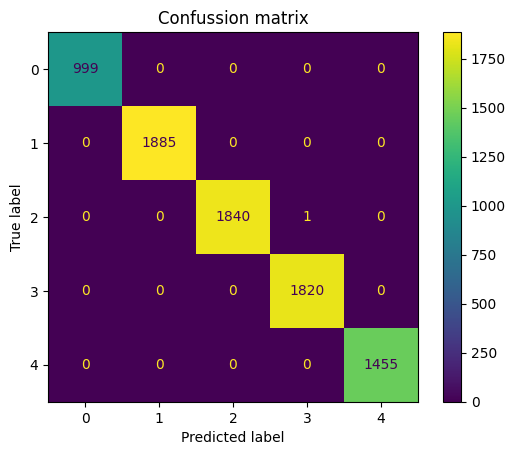

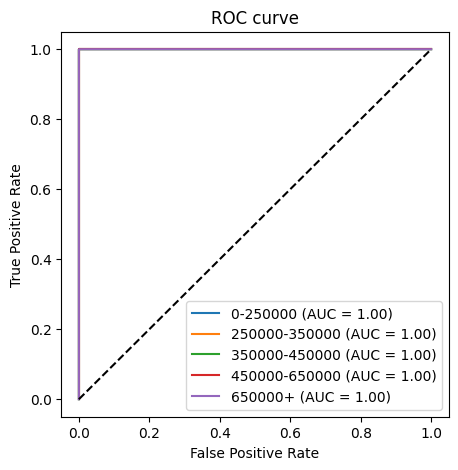

In [338]:
# evaluate train
evaluate_model(rf, X_train, y_train)

              precision    recall  f1-score   support

           0       0.68      0.52      0.59       250
           1       0.58      0.61      0.60       471
           2       0.50      0.53      0.51       460
           3       0.58      0.60      0.59       455
           4       0.80      0.76      0.78       364

    accuracy                           0.61      2000
   macro avg       0.63      0.60      0.61      2000
weighted avg       0.61      0.61      0.61      2000



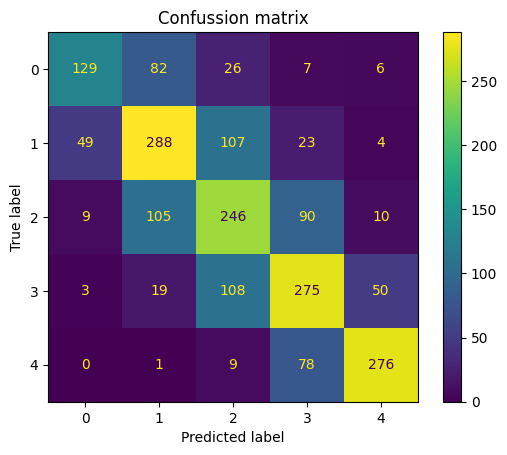

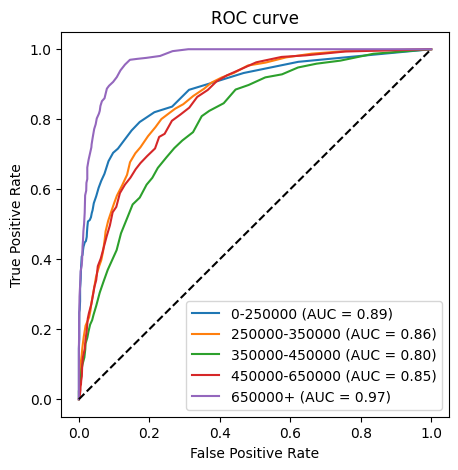

In [339]:
# evaluate test
evaluate_model(rf, X_test, y_test)

In [340]:
joblib.dump(rf, '../models/rf_nestimators_50.bin')

['../models/rf_nestimators_50.bin']

## Hyperparameter tunning

In [322]:
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 4, 6, 8, 10]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 10, 15, 20, 25, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6, 8, 10],
 'min_samples_split': [2, 5, 10, 15, 20],
 'n_estimators': [50, 100, 150, 200]}


In [330]:
# First create the base model to tune
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=18, n_jobs = -1)
rf_random.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=18, verbose=2)

In [357]:
print(f"Best parameters: {rf_random.best_params_}")
print(f"Best score: {rf_random.best_score_}")
print(f"Mean cv test accuracy: {rf_random.cv_results_['mean_test_score'].mean()}")
print(f"Mean std cv test accuracy: {rf_random.cv_results_['std_test_score'].mean()}")

Best parameters: {'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}
Best score: 0.6212500000000001
Mean cv test accuracy: 0.6063137499999999
Mean std cv test accuracy: 0.013839914425103654


In [332]:
best_rf = rf_random.best_estimator_

              precision    recall  f1-score   support

           0       0.96      0.70      0.81       999
           1       0.84      0.88      0.86      1885
           2       0.82      0.87      0.84      1841
           3       0.85      0.88      0.87      1820
           4       0.92      0.93      0.93      1455

    accuracy                           0.86      8000
   macro avg       0.88      0.85      0.86      8000
weighted avg       0.87      0.86      0.86      8000



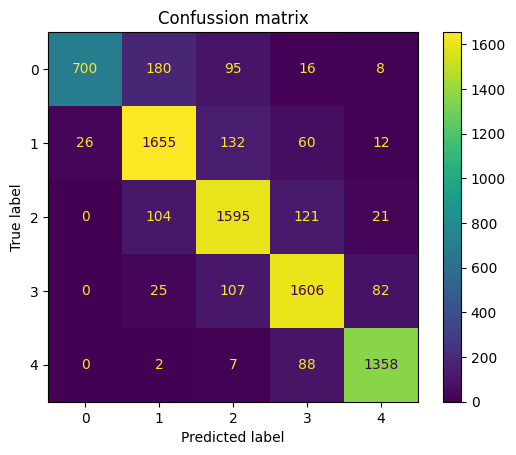

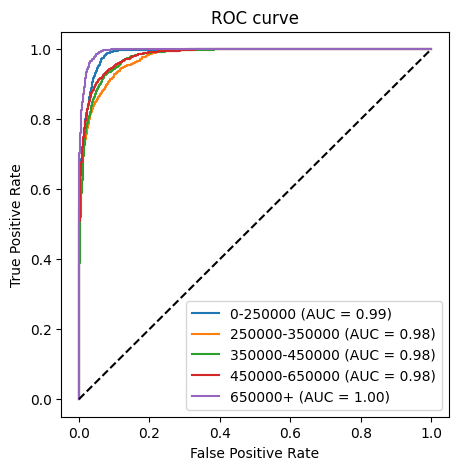

In [333]:
# evaluate train
evaluate_model(best_rf, X_train, y_train)

              precision    recall  f1-score   support

           0       0.75      0.48      0.58       250
           1       0.59      0.64      0.61       471
           2       0.49      0.52      0.50       460
           3       0.57      0.60      0.59       455
           4       0.78      0.77      0.78       364

    accuracy                           0.61      2000
   macro avg       0.64      0.60      0.61      2000
weighted avg       0.62      0.61      0.61      2000



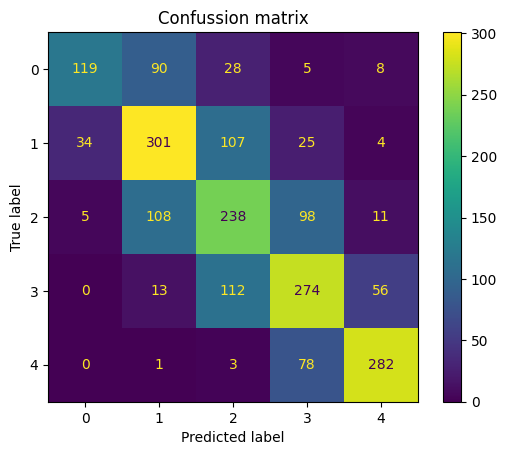

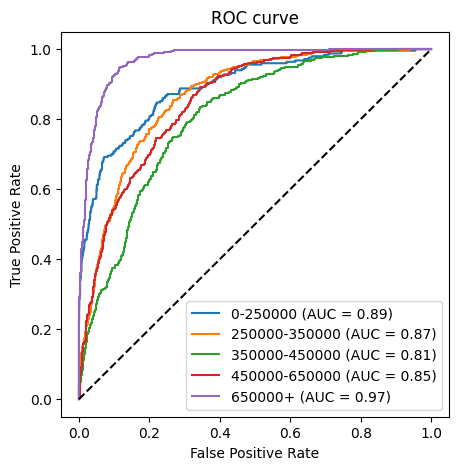

In [334]:
# evaluate test
evaluate_model(best_rf, X_test, y_test)

In [347]:
exp_name = 'random_search_'
for k,v in rf_random.best_params_.items():
    exp_name += k + '_' + str(v) + '_'
joblib.dump(rf, f'../models/rf_{exp_name}.bin')

['../models/rf_random_search_n_estimators_150_min_samples_split_15_min_samples_leaf_2_max_features_sqrt_max_depth_15_bootstrap_False_.bin']

# Train XGBoost

In [348]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=150, max_depth=15, random_state=18)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

## Evaluation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       1.00      1.00      1.00      1885
           2       1.00      1.00      1.00      1841
           3       1.00      1.00      1.00      1820
           4       1.00      1.00      1.00      1455

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



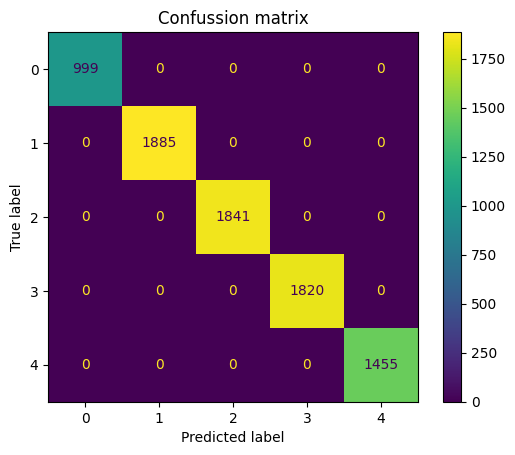

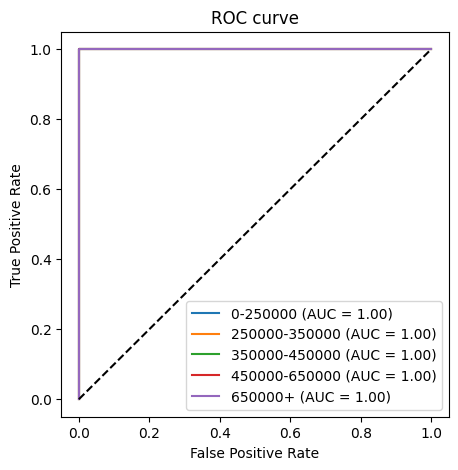

In [349]:
# evaluate train
evaluate_model(xgb, X_train, y_train)

              precision    recall  f1-score   support

           0       0.67      0.53      0.59       250
           1       0.59      0.62      0.61       471
           2       0.49      0.55      0.52       460
           3       0.58      0.55      0.57       455
           4       0.79      0.79      0.79       364

    accuracy                           0.61      2000
   macro avg       0.63      0.61      0.62      2000
weighted avg       0.61      0.61      0.61      2000



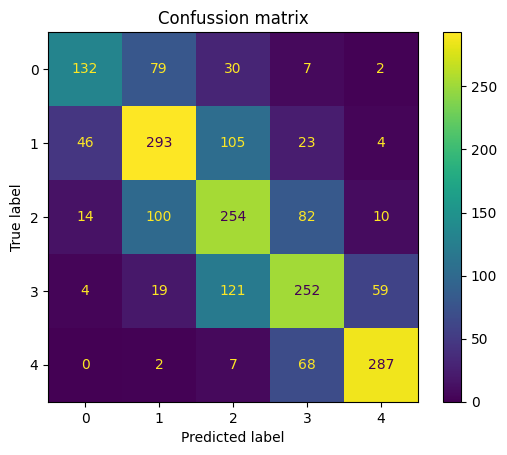

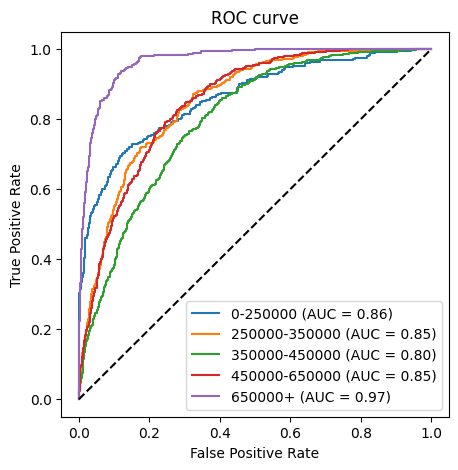

In [350]:
# evaluate test
evaluate_model(xgb, X_test, y_test)